In [1]:
#imports
import skimage
from skimage import segmentation
from skimage.segmentation import slic
import imageio.v2 as imageio
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.measure import regionprops

In [2]:
# Paths to the images
image_path = '..\\dots_and_globues\\PAT_166_257_586.png'
mask_path = '..\\dots_and_globues\\PAT_166_257_586_mask.png'

# Load the image and the mask
im_rgb = imread(image_path)
mask = imread(mask_path)

In [3]:
# Function to create a figure
def create_figure(size=(8, 8)):
    return plt.figure(figsize=size)

# Function to display an image in a subplot
def show_image(image, title='', pos=None):
    if pos is not None:
        plt.subplot(pos)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

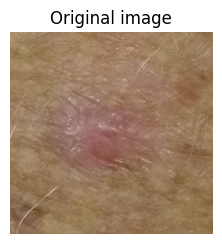

In [4]:
# Show image
create_figure((12, 6))
show_image(np.clip(im_rgb, 0, 256), title='Original image', pos=241)
plt.show()

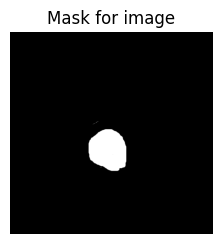

In [5]:
#show mask
create_figure((12,6))
show_image(np.clip(mask, 0, 256), title='Mask for image', pos=241)
plt.show()

In [6]:
def find_topbottom(mask):
    '''
    Function to get top / bottom boundaries of lesion using a binary mask.
    :mask: Binary image mask as numpy.array
    :return: top, bottom as int
    '''
    region_row_indices = np.where(np.sum(mask, axis = 1) > 0)[0]
    top, bottom = region_row_indices[0], region_row_indices[-1]
    return top, bottom

In [7]:
def find_leftright(mask):
    '''
    Function to get left / right boundaries of lesion using a binary mask.
    :mask: Binary image mask as numpy.array
    :return: left, right as int
    '''

    region_column_indices = np.where(np.sum(mask, axis = 0) > 0)[0]
    left, right = region_column_indices[0], region_column_indices[-1]
    return left, right

In [8]:
def lesionMaskCrop(im_rgb, mask):
    '''
    This function masks and crops an area of a color image corresponding to a binary mask of same dimension.

    :image: RGB image read as numpy.array
    :mask: Corresponding binary mask as numpy.array
    '''
    # Getting top/bottom and left/right boundries of lesion
    top, bottom = find_topbottom(mask)
    left, right = find_leftright(mask)

    # Masking out lesion in color image
    im_masked = im_rgb.copy()
    im_masked[mask==0] = 0 # color 0 = black

    # Cropping image using lesion boundaries
    im_crop = im_masked[top:bottom+1,left:right+1]

    return(im_crop)

In [9]:
def rgb_to_hsv(r, g, b):

    """
    Credit for the entire function goes to: 
    https://www.w3resource.com/python-exercises/math/python-math-exercise-77.php
    """
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = (df/mx)*100
    v = mx*100
    return h, s, v

im_lesion = lesionMaskCrop(im_rgb, mask)

segments = slic(im_lesion, n_segments=60, compactness=5, sigma=1, start_label=1)

#show segments
def show_segments(segments=segments):
    create_figure((12,6))
    show_image(np.clip(segments, 0, 256), title='Segments of image', pos=241)
    return(plt.show())

In [10]:
def getColorFeatures(im_rgb, mask):

    """
    TODO: Add rest of the description

    This function computes the color brightness variations of an image, quantified as the IQR. This method 
    uses SLIC segmentation to select superpixels for grathering average regional color intensities. 
    These averages are converted to HSV to measure the spread of brightness ('Value') across all regions.

    :image: RGB image read as numpy.array
    :mask: Corresponding binary mask as numpy.array
    :return: list with extracted features
    """

    # Mask and crop image to only contain lesion
    im_lesion = lesionMaskCrop(im_rgb, mask)

    # Get SLIC boundaries
    segments = slic(im_lesion, n_segments=60, compactness=5, sigma=1, start_label=1)

    # Fetch RegionProps - this includes min/mean/max values for color intensity
    regions = regionprops(segments, intensity_image=im_lesion)

    # Access mean color intensity for each region
    mean_intensity = [r.mean_intensity for r in regions]

    # Get only segments with color in them
    color_intensity = []
    for mean in mean_intensity:
        if sum(mean) != 0:
            color_intensity.append(mean)

    # Convert RGB color means to HSV
    color_mean_hsv = [rgb_to_hsv(col_int[0], col_int[1], col_int[2]) for col_int in color_intensity]

    # Extract values for hue
    color_mean_hue = [hsv[0] for hsv in color_mean_hsv]

    return color_mean_hue


In [11]:
def how_many_colours_are_there(im_rgb, mask, hue_range = 60):

    max_possible_colours = int(360/hue_range) #int will round the value down, but this is counterbalanced by the use of 360 rather than 359

    hues_for_all_regions = getColorFeatures(im_rgb=im_rgb, mask=mask)
    hues_for_all_regions = sorted(hues_for_all_regions)
    #print("count of hues below")
    #print(len(hues_for_all_regions))
    #print("max", max(hues_for_all_regions))
    #print("min", min(hues_for_all_regions))

    first_colour = hues_for_all_regions[0]
    number_of_colours =1
    lower_bound_for_next_colour = first_colour + hue_range
    
    for hue in hues_for_all_regions:
        if hue > lower_bound_for_next_colour:
            lower_bound_for_next_colour = hue + hue_range
            if lower_bound_for_next_colour > 360:
                break
            number_of_colours +=1
    
    if (hue - 360 + hue_range) > first_colour:
        number_of_colours -= 1

    if max_possible_colours < number_of_colours or number_of_colours < 0:
        return("Error in colour count")
    else:
        return(number_of_colours)

    

first_number = 0
num_numbers = 1
lower_bound_next = first_number + 60
expected_count=int(360/35)
print(expected_count)

for fake_hue in range(0,360,35):
    if fake_hue > lower_bound_next:
        lower_bound_next = fake_hue + 60
        if lower_bound_next > 360:
            break
        num_numbers +=1
        
        print("count" ,num_numbers)
        print("fake hue" ,fake_hue)
        print("lbn" ,lower_bound_next)
        print("#####")

if (fake_hue - 360 + 60) > first_number:
    num_numbers -= 1
    print("final answer", num_numbers)

In [12]:
how_many_colours_are_there(im_rgb=im_rgb, mask=mask, hue_range=17)

2